# Projective distortion

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


bgr_target = cv2.imread('./pictures/publicitaire_banner.jpg')
bgr_target = cv2.cvtColor(bgr_target, cv2.COLOR_BGR2BGRA)
rgb_target = cv2.cvtColor(bgr_target, cv2.COLOR_BGRA2RGBA)

bgr_gon = cv2.imread('./pictures/gon_landscape.jpg')
bgr_gon = cv2.cvtColor(bgr_gon, cv2.COLOR_BGR2BGRA)
rgb_gon = cv2.cvtColor(bgr_gon, cv2.COLOR_BGRA2RGBA)

result = bgr_target.copy()

print(rgb_gon.shape)
srcCornerList= np.array([
    [0,0], #top left corner
    [0,bgr_gon.shape[0]], #bottom left corner
    [bgr_gon.shape[1],0], # top right corner
    [bgr_gon.shape[1],bgr_gon.shape[0]] # bottom right corner
],np.float32)

dest2CornerList = np.array([
    [654,110], # top left corner
    [658,331], # bottom left corner
    [984,129], # top right corner
    [1002,330] # bottom right corner
],np.float32)


transform = cv2.getPerspectiveTransform(srcCornerList,dest2CornerList)
print(transform)
cv2.warpPerspective(src=bgr_gon,dst=bgr_target,M=transform,dsize = (bgr_target.shape[1],bgr_target.shape[0]), borderMode=cv2.BORDER_TRANSPARENT)
rgb_target = cv2.cvtColor(bgr_target, cv2.COLOR_BGRA2RGBA)
rgb_result = cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA)

fig = plt.figure(figsize=(20, 20))
plt.subplot(3,1,1)
plt.imshow(rgb_gon) 
plt.subplot(3,1,2)
plt.imshow(rgb_result)
plt.subplot(3,1,3)
plt.imshow(rgb_target)
plt.show()

(204, 341, 4)
[[ 1.25421050e+00 -1.28417169e-01  6.54000000e+02]
 [ 9.32738055e-02  1.00887090e+00  1.10000000e+02]
 [ 2.91126592e-04 -2.24962024e-04  1.00000000e+00]]


<Figure size 2000x2000 with 3 Axes>

# SIFT and Image stitching

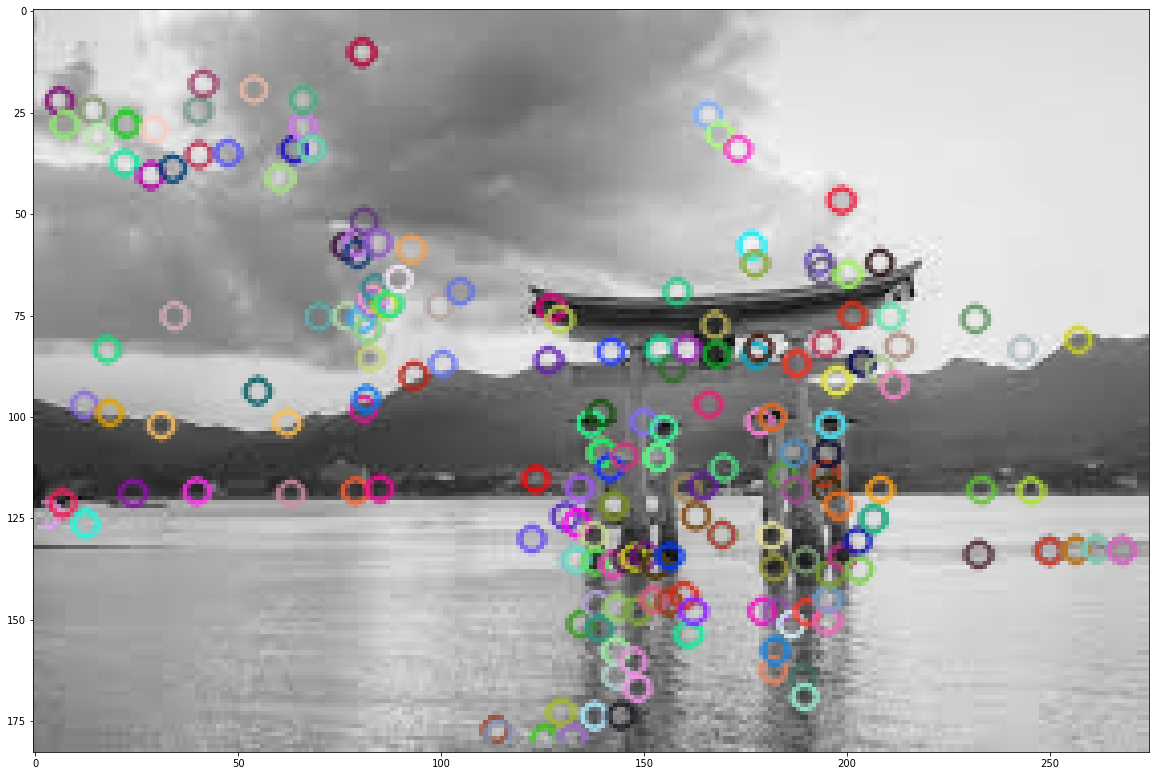

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('./pictures/tori.jpeg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img)

fig = plt.figure(figsize=(20, 20))
plt.imshow(img)

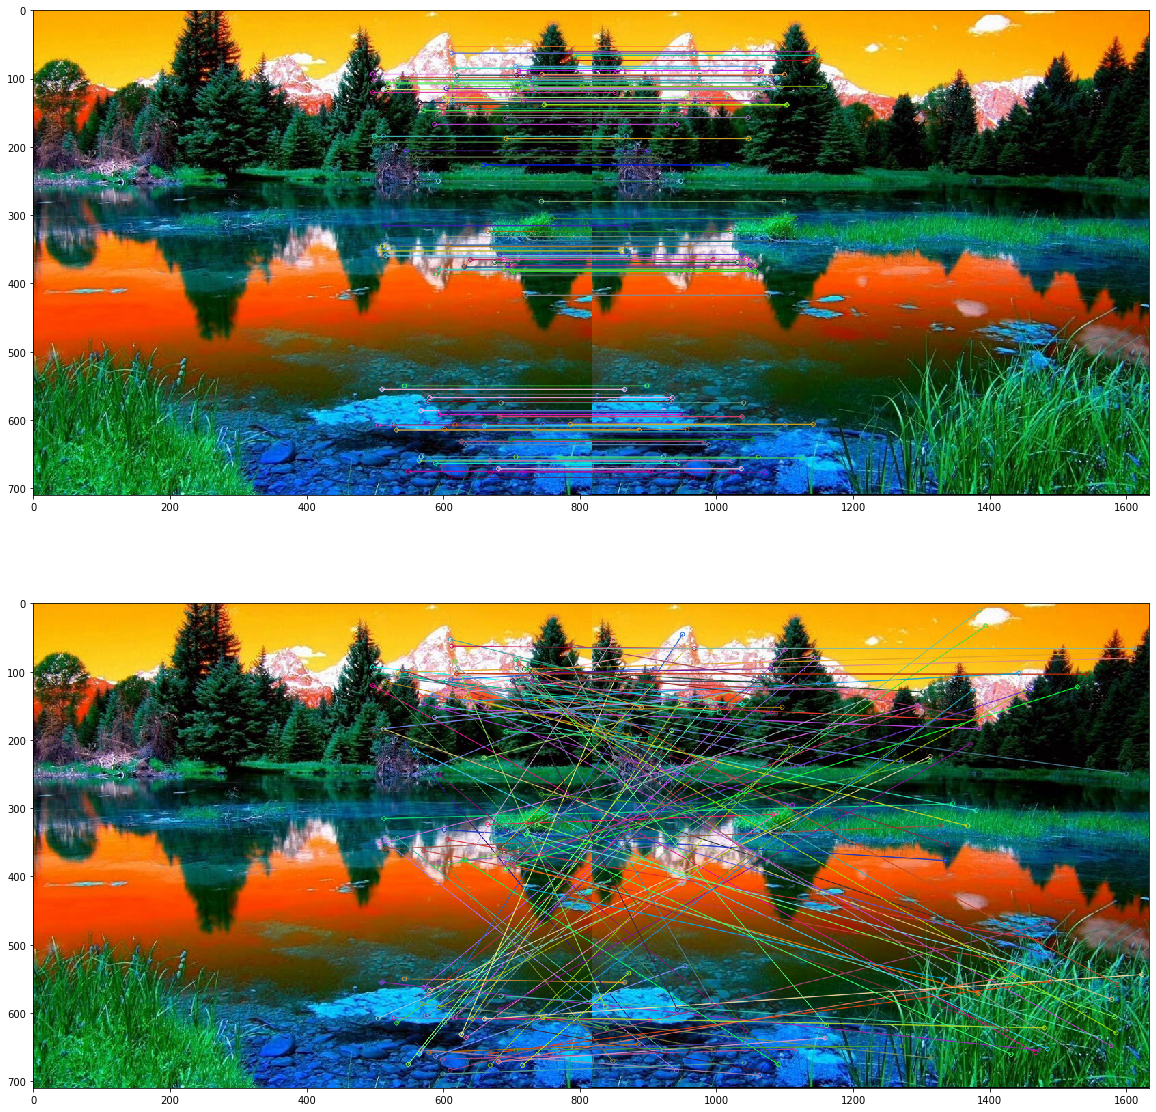

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


img_query = cv2.imread('./pictures/left.jpg')
img1 = cv2.cvtColor(img_query,cv2.COLOR_BGR2GRAY)


img_train = cv2.imread('./pictures/right.jpg')
img2 = cv2.cvtColor(img_train,cv2.COLOR_BGR2GRAY)


sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bfMatcher = cv2.BFMatcher()

matches = bfMatcher.knnMatch(des1,des2,k=2)

good = [(m,n) for (m,n) in matches if m.distance < 0.03*n.distance]

good_1 = [m for (m,n) in matches if m.distance < 0.03*n.distance]
good_2 = [n for (m,n) in matches if m.distance < 0.03*n.distance]

matches1DrawImg = cv2.drawMatches(img_query,kp1,img_train,kp2,good_1,None,flags= cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
matches2DrawImg = cv2.drawMatches(img_query,kp1,img_train,kp2,good_2,None,flags= cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#plt.subplot(3,1,1)
#plt.imshow(cropRightImg)
#plt.subplot(3,1,2)
#plt.imshow(cropLeftImg)

fig = plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.imshow(matches1DrawImg)
plt.subplot(2,1,2)
plt.imshow(matches2DrawImg)

#warpPerspective 
#getPerspectiveTransform

In [4]:
# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)



[[467.7631  569.0328 ]
 [468.84293 666.8987 ]
 [469.3663  618.55457]
 ...
 [811.2234  164.19055]
 [811.85034 658.918  ]
 [812.77167 165.03   ]]
[[467.7631  569.0328 ]
 [468.84293 666.8987 ]
 [469.3663  618.55457]
 ...
 [811.2234  164.19055]
 [811.85034 658.918  ]
 [812.77167 165.03   ]]
[[ 1.00003016e+00  1.32571278e-05 -4.63014879e+02]
 [ 7.98656468e-06  1.00003649e+00 -3.80689935e-03]
 [ 1.18569828e-07 -5.84131861e-08  1.00000000e+00]]


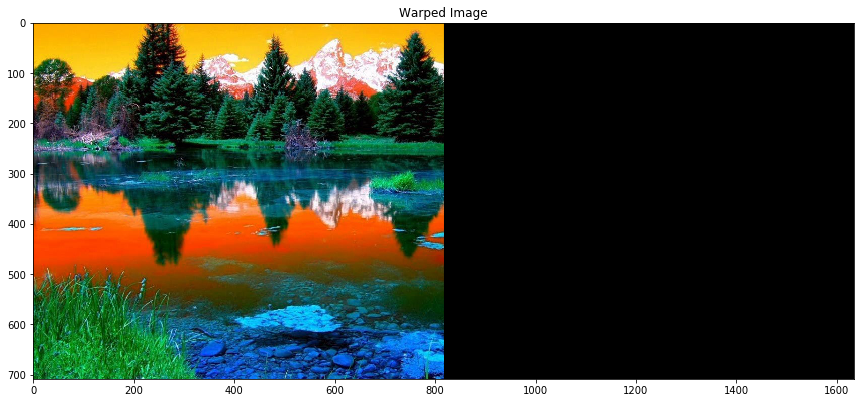

<Figure size 432x288 with 0 Axes>

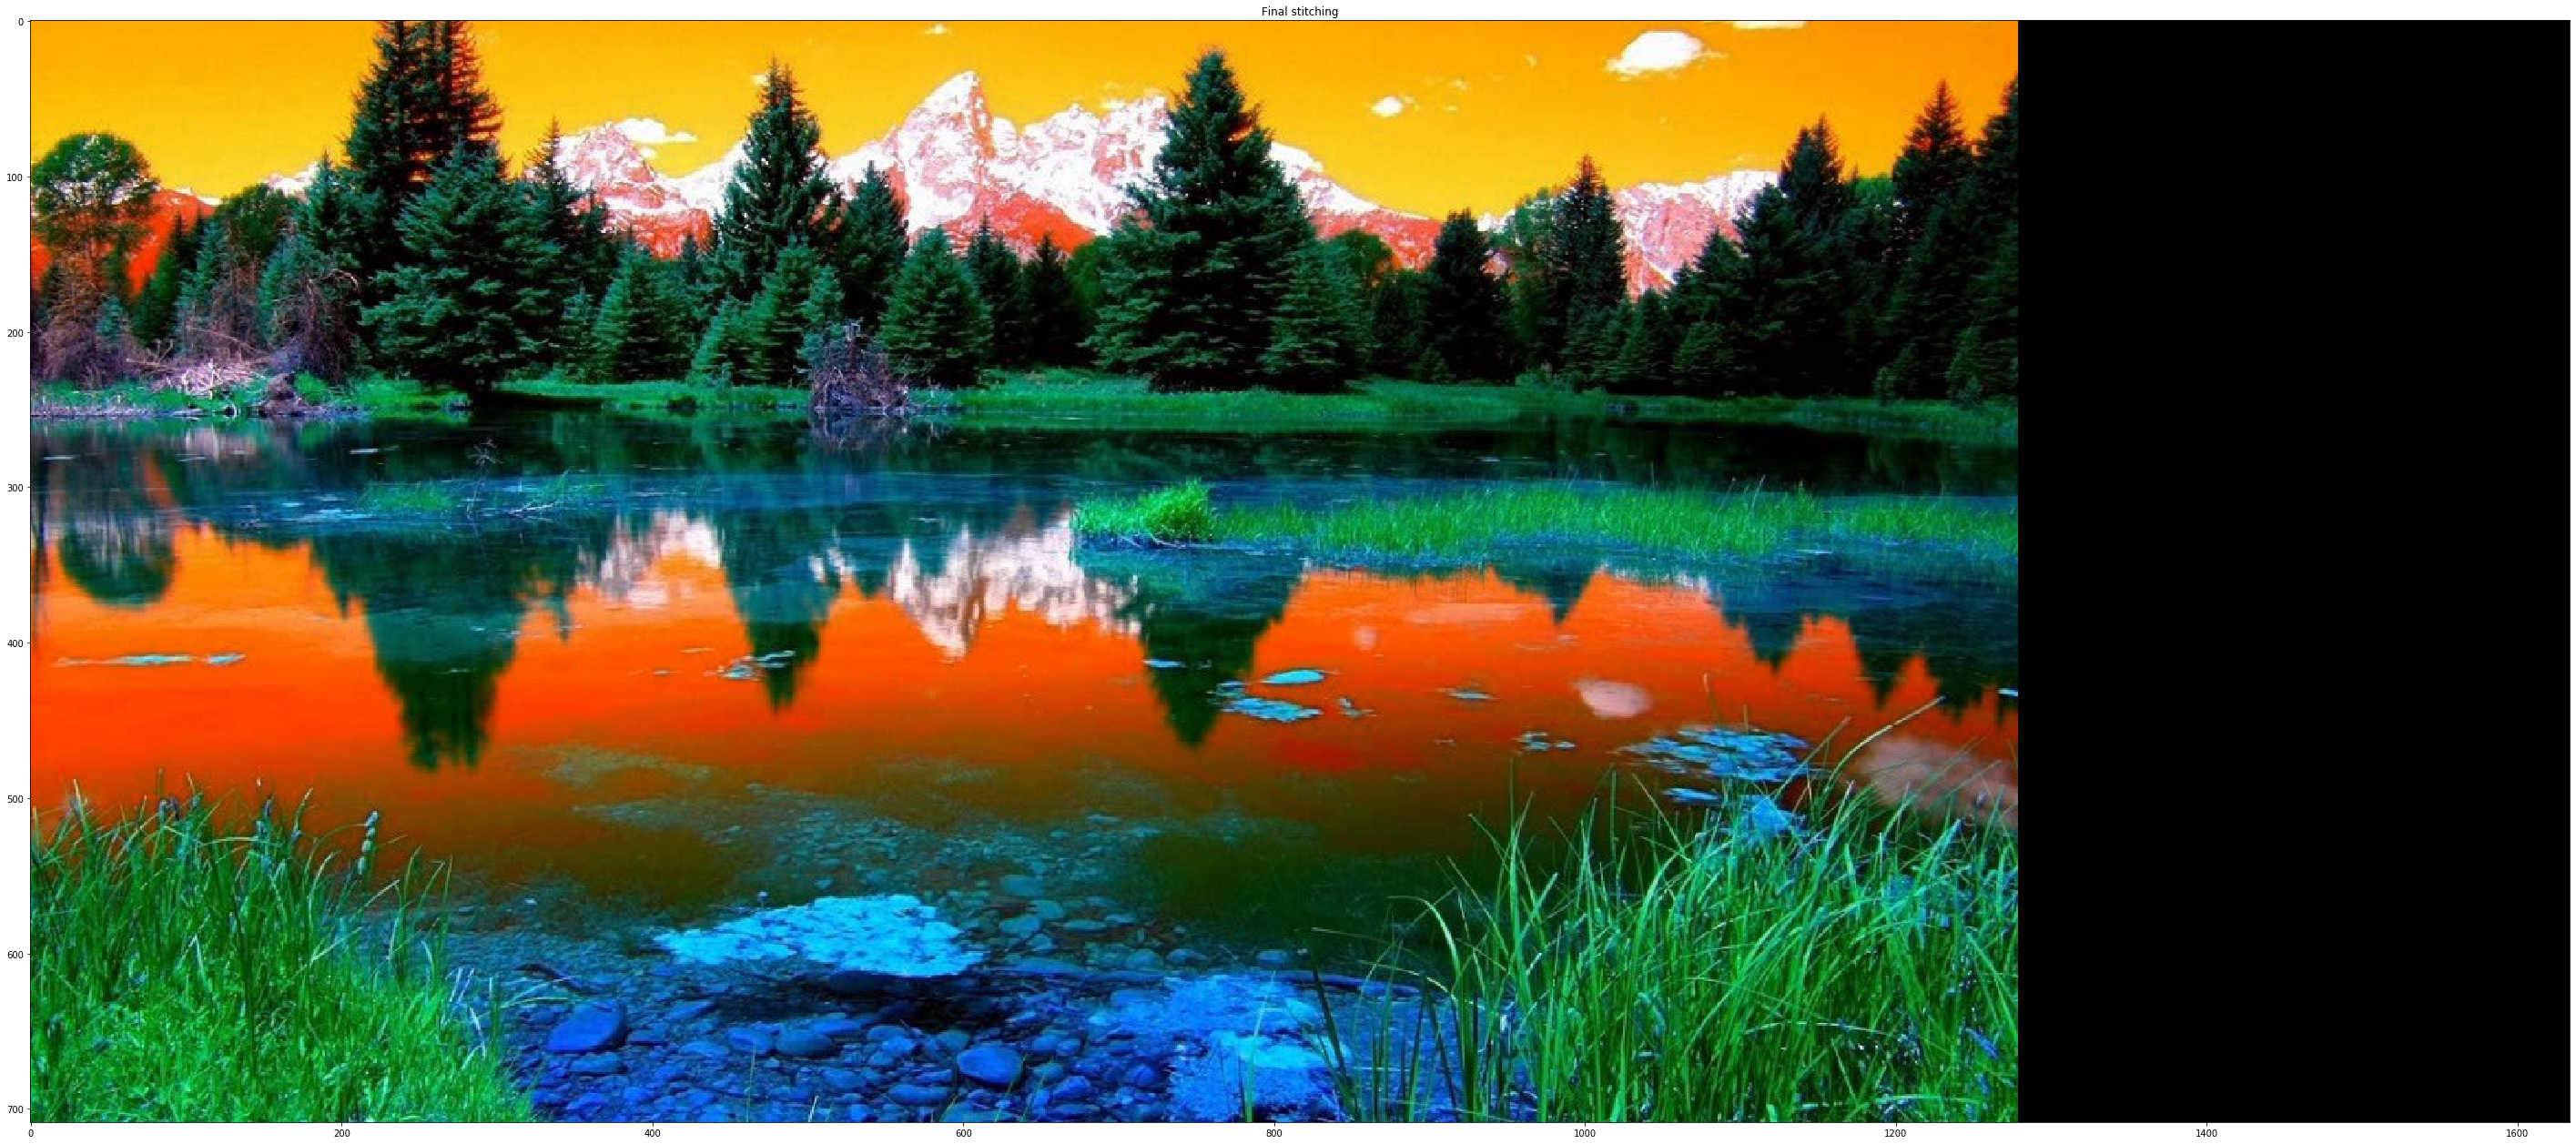

In [31]:
src = np.float32([ kp1[m.queryIdx].pt for m,n in matches])
dst = np.float32([ kp2[m.trainIdx].pt for m,n in matches])
H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

# Recenter the translation 
# The homography can take the picture out of bounds so we will apply the inverse translation to the train img

print(H)
shift_x = (-1) * H[0][2];
shift_y = (-1) * H[1][2];

H[0][2] = 0;
H[1][2] = 0;

width = img_train.shape[1] + img_query.shape[1]
height = img_train.shape[0]

dst = cv2.warpPerspective(img_query,H,(width,height))
fig = plt.figure(figsize=(50, 50))
plt.subplot(4,1,1)
plt.imshow(img_query)
plt.subplot(4,2,1)
plt.imshow(img_train)
plt.subplot(4,3,1)
plt.imshow(dst)
plt.title('Warped Image')
plt.show()
plt.figure()

dst[int(shift_y):img_train.shape[0]+int(shift_y), int(shift_x):img_train.shape[1]+int(shift_x)] = img_train
fig = plt.figure(figsize=(50, 50))
plt.imshow(dst)
plt.title('Final stitching')
plt.show()